## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# for neural network
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import resnet18
from copy import deepcopy

# for splitting data and evaluating results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# to track progress
from tqdm.notebook import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## get data

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True
)

train_inputs, train_labels = zip(*train_dataset)
test_inputs, test_labels = zip(*test_dataset)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def toNumpy(x):
  return np.array([np.array(i, dtype=float) for i in x])/255      # normalize to [0,1]

train_inputs, train_labels = toNumpy(train_inputs), np.array(train_labels)
test_inputs, test_labels = toNumpy(test_inputs), np.array(test_labels)

print(train_inputs.shape)
print(test_inputs.shape)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("classes:",np.unique(train_labels))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
classes: [0 1 2 3 4 5 6 7 8 9]


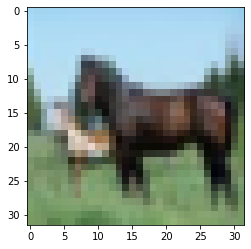

In [5]:
# plot sample
plt.imshow(train_inputs[12])

## create dataset and dataloader

In [6]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, labels, transform):
    self.inputs = inputs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.transform(self.inputs[index])
    label = self.labels[index]
    return input,label

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = mydataset(train_inputs, train_labels, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = mydataset(test_inputs, test_labels, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

dataloaders = {"train":train_loader}

## define train function

In [7]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,labelBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device).float()
          labelBatch = labelBatch.to(device)
          
          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outputBatch = model(inputBatch)
          loss = criterion(outputBatch, labelBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      print(" | ", end='')
      for phase in phases:        
        print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  end_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, end_params

## create model and train

In [8]:
model = resnet18().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=9e-1)

training model


epoch: 1  | train loss: 1.945,  | avg train loss: 1.945, 

epoch: 2  | train loss: 1.356,  | avg train loss: 1.356, 

epoch: 3  | train loss: 1.132,  | avg train loss: 1.132, 

epoch: 4  | train loss: 0.989,  | avg train loss: 0.989, 

epoch: 5  | train loss: 0.876,  | avg train loss: 0.876, 

epoch: 6  | train loss: 0.779,  | avg train loss: 0.779, 

epoch: 7  | train loss: 0.701,  | avg train loss: 0.701, 

epoch: 8  | train loss: 0.623,  | avg train loss: 0.623, 

epoch: 9  | train loss: 0.565,  | avg train loss: 0.565, 

epoch: 10  | train loss: 0.503,  | avg train loss: 0.503, 
Finished Training


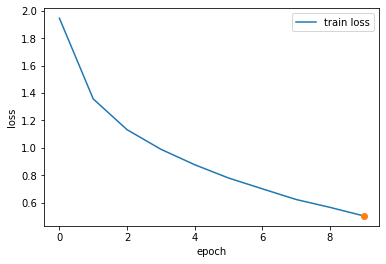

In [9]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, epochs=10)

In [10]:
model.load_state_dict(best_params)

<All keys matched successfully>

## evaluate

In [11]:
def evaluate(net, loader):

  net.eval()
  output_pred = []
  output_true = []

  for i, (inputBatch,labelBatch) in enumerate(tqdm(loader)):
      inputBatch = inputBatch.to(device).float()
      labelBatch = labelBatch.to(device)

      # forward
      with torch.no_grad():
        outputBatch = net(inputBatch)
      for output, label in zip(outputBatch,labelBatch):
        output_true.append(label.cpu().numpy())
        val, indx = torch.max(output,0)
        output_pred.append(indx.cpu().numpy())

  #print(classification_report(output_true, output_pred, target_names=classes, digits=4))
  cm = confusion_matrix(output_true, output_pred)
  classesAcc = cm.diagonal()/cm.sum(axis=1)

  print("{:<8} {:<15}".format("Class","Accuracy"))
  for claSS, classAcc in zip(classes,classesAcc):
    print("{:<8} {:<15}".format(claSS,classAcc))

  return classesAcc    

In [12]:
print("evaluation results on test data")
res1 = evaluate(model,test_loader)

evaluation results on test data



Class    Accuracy       
plane    0.794          
car      0.881          
bird     0.552          
cat      0.605          
deer     0.738          
dog      0.591          
frog     0.795          
horse    0.78           
ship     0.784          
truck    0.712          


## occlusion experiment 1

Alternating pixels set to 0.5

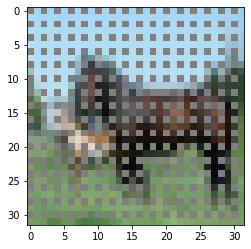

In [13]:
OcclTrain_inputs, OcclTest_inputs = np.array(train_inputs), np.array(test_inputs)
OcclTrain_inputs[:,::2,::2] = 0.5;  OcclTest_inputs[:,::2,::2] = 0.5

plt.imshow(OcclTrain_inputs[12])

### create dataset and dataloader

In [14]:
train_dataset = mydataset(OcclTrain_inputs, train_labels, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = mydataset(OcclTest_inputs, test_labels, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

dataloaders = {"train":train_loader}

### create model and train

In [15]:
model = resnet18().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=9e-1)

training model


epoch: 1  | train loss: 2.027,  | avg train loss: 2.027, 

epoch: 2  | train loss: 1.465,  | avg train loss: 1.465, 

epoch: 3  | train loss: 1.267,  | avg train loss: 1.267, 

epoch: 4  | train loss: 1.096,  | avg train loss: 1.096, 

epoch: 5  | train loss: 0.957,  | avg train loss: 0.957, 

epoch: 6  | train loss: 0.848,  | avg train loss: 0.848, 

epoch: 7  | train loss: 0.756,  | avg train loss: 0.756, 

epoch: 8  | train loss: 0.694,  | avg train loss: 0.694, 

epoch: 9  | train loss: 0.602,  | avg train loss: 0.602, 

epoch: 10  | train loss: 0.530,  | avg train loss: 0.530, 
Finished Training


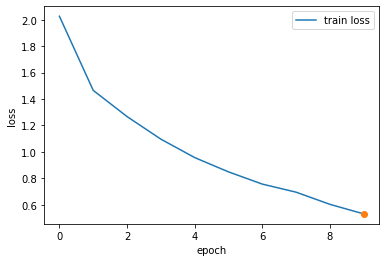

In [16]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, epochs=10)

### evaluate

In [17]:
print("evaluation results on test data")
res2 = evaluate(model,test_loader)

evaluation results on test data



Class    Accuracy       
plane    0.593          
car      0.669          
bird     0.676          
cat      0.567          
deer     0.561          
dog      0.603          
frog     0.726          
horse    0.803          
ship     0.864          
truck    0.74           


## occlusion experiment 2

Center square set to 0.5 occupying 25% of the image 

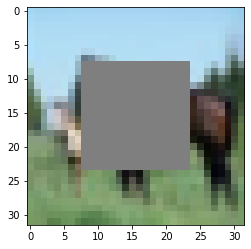

In [18]:
OcclTrain_inputs, OcclTest_inputs = np.array(train_inputs), np.array(test_inputs)
OcclTrain_inputs[:,8:24,8:24] = 0.5;  OcclTest_inputs[:,8:24,8:24] = 0.5

plt.imshow(OcclTrain_inputs[12])

### create dataset and dataloader

In [19]:
train_dataset = mydataset(OcclTrain_inputs, train_labels, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = mydataset(OcclTest_inputs, test_labels, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

dataloaders = {"train":train_loader}

### create model and train

In [20]:
model = resnet18().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=9e-1)

training model


epoch: 1  | train loss: 2.047,  | avg train loss: 2.047, 

epoch: 2  | train loss: 1.566,  | avg train loss: 1.566, 

epoch: 3  | train loss: 1.417,  | avg train loss: 1.417, 

epoch: 4  | train loss: 1.287,  | avg train loss: 1.287, 

epoch: 5  | train loss: 1.168,  | avg train loss: 1.168, 

epoch: 6  | train loss: 1.082,  | avg train loss: 1.082, 

epoch: 7  | train loss: 1.021,  | avg train loss: 1.021, 

epoch: 8  | train loss: 1.017,  | avg train loss: 1.017, 

epoch: 9  | train loss: 0.895,  | avg train loss: 0.895, 

epoch: 10  | train loss: 0.821,  | avg train loss: 0.821, 
Finished Training


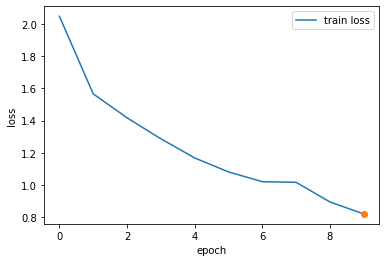

In [21]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, epochs=10)

### evaluate

In [22]:
print("evaluation results on test data")
res3 = evaluate(model,test_loader)

evaluation results on test data



Class    Accuracy       
plane    0.809          
car      0.81           
bird     0.466          
cat      0.437          
deer     0.591          
dog      0.408          
frog     0.716          
horse    0.67           
ship     0.533          
truck    0.785          


## results and conclusion

In [23]:
print("{:<8} {:<10} {:<10} {:<10}".format("Class","Normal","Alternate","Center"))
for claSS, classAcc1, classAcc2, classAcc3 in zip(classes,res1,res2,res3):
  print("{:<8} {:<10} {:<10} {:<10}".format(claSS,classAcc1,classAcc2,classAcc3))

print("\n{:<8} {:<10} {:<10} {:<10}".format("average",np.mean(res1),np.mean(res2),np.mean(res3)))

Class    Normal     Alternate  Center    
plane    0.794      0.593      0.809     
car      0.881      0.669      0.81      
bird     0.552      0.676      0.466     
cat      0.605      0.567      0.437     
deer     0.738      0.561      0.591     
dog      0.591      0.603      0.408     
frog     0.795      0.726      0.716     
horse    0.78       0.803      0.67      
ship     0.784      0.864      0.533     
truck    0.712      0.74       0.785     

average  0.7232     0.6802     0.6225    


It can be observed that the normal images performed the best. \
The images in which alternate pixels were occluded performed 2nd. \
And the images in which center 25% pixels were occluded performed worst.\
\
Eventhough alternating pixels also cover 25% of the image but still they are evenly spread out. \
The 25% covers the center portion which contains more information about the object to be detected, hence it performs the worst.